In [12]:

import numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re, os
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)


device: cpu


In [13]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt"
assert os.path.exists(DATA_PATH), "경로가 올바른지 확인하세요."


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
def load_wisdm_raw(raw_path):
    rows = []
    with open(raw_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # 콤마/공백 섞여 들어오는 경우가 있어 통합 정규화
            parts = re.split('[, ]+', line)
            if len(parts) < 6:
                continue
            user = parts[0]
            activity = parts[1]
            x = parts[-3]
            y = parts[-2]
            z = parts[-1].replace(';','')
            timestamp = ''.join(parts[2:-3])  # 남은 부분을 timestamp로 묶음
            try:
                rows.append([user, activity, int(timestamp), float(x), float(y), float(z)])
            except:
                # 형식 틀어진 라인은 스킵
                continue
    df = pd.DataFrame(rows, columns=['user','activity','timestamp','x','y','z'])
    df = df.sort_values(['user','activity','timestamp']).reset_index(drop=True)
    return df

df = load_wisdm_raw(DATA_PATH)
print(df.shape)
df


(1086465, 6)


,user,activity,timestamp,x,y,z
0,1,Downstairs,6552942304000,-0.15,9.15,-0.34
1,1,Downstairs,6552992292000,0.11,9.19,2.76
2,1,Downstairs,6553042310000,-4.06,7.40,4.02
3,1,Downstairs,6553092298000,-2.87,7.93,3.21
4,1,Downstairs,6553142347000,-0.19,10.04,4.82
...,...,...,...,...,...,...
1086460,9,Walking,9614392347000,12.37,7.70,3.49
1086461,9,Walking,9614442335000,10.84,6.78,1.14
1086462,9,Walking,9614492292000,8.01,5.05,-0.04
1086463,9,Walking,9614542341000,5.86,4.21,-1.18


In [14]:
for col in ['x','y','z']:
    m = df[col].mean()
    s = df[col].std() + 1e-8
    df[col] = (df[col] - m) / s

df[['x','y','z']].describe().round(3)


,x,y,z
count,1086465.000,1086465.000,1086465.000
mean,0.000,-0.000,-0.000
std,1.000,1.000,1.000
min,-2.948,-3.985,-4.242
25%,-0.520,-0.605,-0.550
50%,-0.057,0.101,-0.084
75%,0.549,0.640,0.488
max,2.805,1.898,4.035


In [15]:
# 하이퍼파라미터
WINDOW_SIZE = 128   # 한 윈도우 길이(시점 수)
STEP        = 32    # 이동 간격(작을수록 겹침 많음)

def make_windows_user_activity(df, window_size=WINDOW_SIZE, step=STEP):
    X_list, y_list = [], []
    for (user, activity), g in df.groupby(['user','activity']):
        g = g.sort_values('timestamp')
        arr = g[['x','y','z']].values  # (N,3)
        n = len(arr)
        if n < window_size:
            continue
        for start in range(0, n - window_size + 1, step):
            end = start + window_size
            seg = arr[start:end]              # (window_size, 3)
            X_list.append(seg)
            y_list.append(activity)
    X = np.stack(X_list, axis=0)              # (num_windows, window_size, 3)
    y = np.array(y_list)
    return X, y

X, y = make_windows_user_activity(df, WINDOW_SIZE, STEP)
X.shape, y.shape


((33329, 128, 3), (33329,))

In [16]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)
print("classes:", list(le.classes_), "=>", num_classes)

idx = np.arange(len(X))
np.random.seed(42)
np.random.shuffle(idx)
X, y_enc = X[idx], y_enc[idx]

split = int(len(X)*0.8)
X_train, X_test = X[:split],  X[split:]
y_train, y_test = y_enc[:split], y_enc[split:]

X_train.shape, X_test.shape, len(np.unique(y_train))


classes: [np.str_('Downstairs'), np.str_('Jogging'), np.str_('Sitting'), np.str_('Standing'), np.str_('Upstairs'), np.str_('Walking')] => 6


((26663, 128, 3), (6666, 128, 3), 6)

In [17]:
class WisdmDataset(Dataset):
    def __init__(self, X, y):
        # 1D-CNN 입력: (배치, 채널=3, 길이=window)
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 2, 1)  # (N,3,window)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_ds = WisdmDataset(X_train, y_train)
test_ds  = WisdmDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)
len(train_ds), len(test_ds)


(26663, 6666)

In [18]:
class SimpleCNN1D(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)  # (B,128,1)
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)   # (B,128,1)
        x = x.squeeze(-1)      # (B,128)
        return self.fc(x)      # (B,C)

model = SimpleCNN1D(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [19]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item() * xb.size(0)
        tot_correct += (logits.argmax(1) == yb).sum().item()
        tot += xb.size(0)
    return tot_loss / tot, tot_correct / tot

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    all_pred, all_true = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        tot_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        tot_correct += (pred == yb).sum().item()
        tot += xb.size(0)
        all_pred.append(pred.cpu().numpy())
        all_true.append(yb.cpu().numpy())
    return (tot_loss/tot), (tot_correct/tot), np.concatenate(all_pred), np.concatenate(all_true)

EPOCHS = 5
best_acc = 0.0

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    te_loss, te_acc, te_pred, te_true = evaluate(model, test_loader, criterion)
    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), "best_simple_cnn1d.pt")
    print(f"[{ep:02d}] train {tr_loss:.4f}/{tr_acc:.4f} | test {te_loss:.4f}/{te_acc:.4f}")

print("best test acc:", best_acc)


[01] train 0.5850/0.8171 | test 0.3031/0.9124
[02] train 0.2079/0.9434 | test 0.1764/0.9362
[03] train 0.1078/0.9718 | test 0.0875/0.9776
[04] train 0.0762/0.9787 | test 0.0643/0.9791
[05] train 0.0509/0.9863 | test 0.1255/0.9539
best test acc: 0.9791479147914791



[Classification Report]
              precision    recall  f1-score   support

  Downstairs       0.97      0.89      0.93       592
     Jogging       1.00      0.92      0.96      2047
     Sitting       1.00      0.95      0.98       360
    Standing       0.95      1.00      0.98       283
    Upstairs       0.73      1.00      0.84       748
     Walking       1.00      0.98      0.99      2636

    accuracy                           0.95      6666
   macro avg       0.94      0.96      0.95      6666
weighted avg       0.96      0.95      0.96      6666


Accuracy: 0.9539


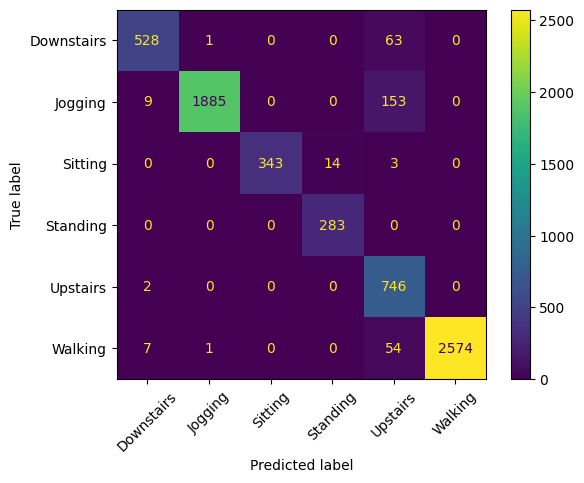


[Random predictions]
true=Walking  pred=Walking
true=Jogging  pred=Jogging
true=Jogging  pred=Jogging
true=Downstairs  pred=Downstairs
true=Walking  pred=Walking
true=Walking  pred=Walking
true=Walking  pred=Walking
true=Walking  pred=Walking
true=Upstairs  pred=Upstairs
true=Walking  pred=Walking


In [20]:
print("\n[Classification Report]")
print(classification_report(te_true, te_pred, target_names=le.classes_))

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(te_true, te_pred)
acc = accuracy_score(te_true, te_pred)
print(f"\nAccuracy: {acc:.4f}")
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.show()

@torch.no_grad()
def show_random_predictions(model, dataset, n=10):
    model.eval()
    import numpy as np
    idxs = np.random.choice(len(dataset), size=min(n, len(dataset)), replace=False)
    for i in idxs:
        xb, yb = dataset[i]
        logits = model(xb.unsqueeze(0).to(device))
        pred = logits.argmax(1).item()
        print(f"true={le.classes_[yb.item()]}  pred={le.classes_[pred]}")

print("\n[Random predictions]")
show_random_predictions(model, test_ds, n=10)
